Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn (SimpleRNN)                 │ (None, 154, 256)       │        66,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 154, 256)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputprobs (Dense)             │ (None, 154, 1)         │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,585 (264.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.1215 - custom_cat: 1.0078 - loss: 1.7497 - val_accuracy: 0.1373 - val_custom_cat: 0.9972 - val_loss: 0.9150
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1375 - custom_cat: 0.9974 - loss: 0.7777 - val_accuracy: 0.1349 - val_custom_cat: 0.9955 - val_loss: 0.8587
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1383 - custom_cat: 0.9970 - loss: 0.7669 - val_accuracy: 0.1394 - val_custom_cat: 0.9972 - val_loss: 0.8090
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1390 - custom_cat: 0.9976 - loss: 0.7685 - val_accuracy: 0.1399 - val_custom_cat: 0.9967 - val_loss: 0.7767
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1393 - custom_cat: 0.9978 - loss: 0.7621 - val_accuracy: 0.1391 - val_custom_cat: 0.9994 - val_loss: 0.7815
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1392 - custom_cat: 0.9978 - loss: 0.7610 - val_accur

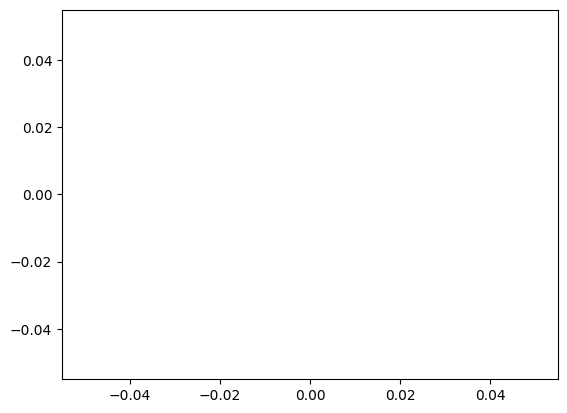

In [2]:
import numpy as np
import sklearn.model_selection as sk
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as kb
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import random

################################################GONNA SWITCH FROM -1,0,1 to 0,1,2
#gonna work in radians

################### GLOBAL VARIABLES

NUMANGLES = 400 #how many orientations each side can take

MAXPROB = .5 #Max probability the mouse is correct


ANGLEMAX = np.pi/2 #maximum bar orientation angle
ANGLEMIN = -np.pi/2 #minimum bar orientation angle

LEFTCHOICEVAL = -1  #Value output when choosing left bar
RIGHTCHOICEVAL = 1 #Value output when choosing right bar

UNITS = 256 # Number of neurons in the dense layer
OUTPUT_SIZE = 1 # Number of output states

STIMULUSDURATION = 6 #length of the stimulus (seconds)
PRESTIMULUSDURATION = 1 #length of the pre stimulus (seconds)

FRAMERATE = 22 #(hz)

TOTALFRAMES = int(FRAMERATE*(STIMULUSDURATION + PRESTIMULUSDURATION)) #total number of frames

LASTFRAME = TOTALFRAMES - 1 #index of the last frame

PRESTIMULUSFRAME = int(PRESTIMULUSDURATION * FRAMERATE - 1) #index of the frame immediately before stimulus

################################################################################################################################## END GLOBAL VARIABLES


angleList = np.linspace(ANGLEMAX, ANGLEMIN, NUMANGLES) #list of all angles to be trained on

def difficulty(angle1, angle2):
    '''Uses fancy but probably unecessarily complicated math to assign a difficulty to two input angles
       Difficulty ranges from 0 to 1'''
    sameSign = True
    difference = abs( abs(angle1) - abs(angle2) )

    if abs(angle1 + angle2) < abs(angle1)+abs(angle2): #if they are opposite sign
        sameSign = False
        
    beta = 0.06 #slope parameter for steepness of difficulty curve (a function of angle separation)
    alpha = .1 #Value of difficulty at angle difference of max

    offset = np.arctanh( 2*alpha - 1 )/beta #shift the graph so at x = 0 f(x) is alpha

    f = .4 #Parameter for the slope of the mapping of difference to input to the difficulty function
    
    if not sameSign: #the angles are not the same side so add a bias to the difficulty
        y = 0.6  #parameter affecting how much f is changed when the angles are on same side or not
        f = f - y*f

    x = 1/(f*difference) #scale it so small differences are large value and big differences are small
    dif = 1/2 * ( np.tanh( beta * (x + offset) ) + 1 )
    return dif


#Generate training data

#list that holds the pairs [left angle, right angle]
anglePairs = []

#generate all pairs of angles
for i in angleList:
    for j in angleList:      #round to deal with floating point error
        decimals = 1
        if (round(i,decimals) != round(j,decimals)) & (-round(i,decimals) != round(j,decimals)): #we dont want any pairs that have equal verticallity (same abs(angle))
            #add noise to the angles
            noiseScale = 10 #scales how noise the angles are
            i += np.random.randn()/noiseScale
            j += np.random.randn()/noiseScale
            anglePairs.append([i,j])


#make the list a np array 
angPair = np.zeros((len(anglePairs), 2))
counter = 0
for i in anglePairs:
    angPair[counter][0] = i[0]
    angPair[counter][1] = i[1]
    counter +=1
anglePairs = angPair

np.random.shuffle(anglePairs) #randomly organize list for training


def correctChoice(angle1, angle2):
    '''input 2 angles return the smaller angle corresponding to more vertical orientation
       Angle 1 is left angle 2 is right. Returns -1 for Left 1 for right
       if they are equal error is thrown because currently only training on non equal angles
    '''
    global LEFTCHOICEVAL, RIGHTCHOICEVAL
    if angle1 < angle2:
        return LEFTCHOICEVAL        #The left bar is oriented more vertically
    elif angle2 < angle1:
        return RIGHTCHOICEVAL        #The right bar is oriented more vertically
    else:
        return "Error. Not expecting equal angles" #throw error if angles are equal


def trainedChoice(angle1, angle2):
    '''Input two angles returns the choice the mouse makes'''
    global LEFTCHOICEVAL, RIGHTCHOICEVAL

    cor = correctChoice(angle1,angle2)

    n = np.random.random()

    if n <= probablilityCorrect(difficulty(angle1, angle2)): #they are certain
        return cor
    else:#not certain so take a guess
        g = np.random.rand()
        if g < .5:
            return cor
        else:
            if cor == RIGHTCHOICEVAL:
                return LEFTCHOICEVAL
            else:
                return RIGHTCHOICEVAL
            
def probablilityCorrect(difficulty):
    '''takes an input difficulty ranging from 0 to 1 and outputs a probability from .5 to 1 corresponding to the prob the mouse is correct'''
    global MAXPROB
    p = -0.5*difficulty + 1
    if p > MAXPROB:
        p = MAXPROB
    return p


    
numberTrials = len(anglePairs)

#create the lists of trained and correct choices
corCh = np.zeros(numberTrials) #List of correct choices
trainedCh = np.zeros(numberTrials) #List of trained choices

counter = 0
for i in anglePairs:
    angle1 = i[0]
    angle2 = i[1]
    corCh[counter] = correctChoice(angle1, angle2)
    trainedCh[counter] = trainedChoice(angle1, angle2)
    counter += 1

 




trialsData = np.zeros((numberTrials, TOTALFRAMES, 2)).astype(np.float32) #stores the trials time series'. This is the input time series

responseData = np.full((numberTrials, TOTALFRAMES), np.nan) #stores the response time series. This is the output




for iteration in range(numberTrials): #for each experiment create a time series
    for frame in range(TOTALFRAMES): 
        if frame <= PRESTIMULUSFRAME: #startwith [0,0] when no stimulus present
            g = np.random.randint(0,3)
            if g ==0:
                trialsData[iteration][frame][0] = np.pi
                trialsData[iteration][frame][1] = np.pi
            elif g ==1:
                trialsData[iteration][frame][0] = -np.pi
                trialsData[iteration][frame][1] = -np.pi
            elif g ==2:
                trialsData[iteration][frame][0] = np.pi
                trialsData[iteration][frame][1] = -np.pi   
            elif g ==3:
                trialsData[iteration][frame][0] = -np.pi
                trialsData[iteration][frame][1] = np.pi
                
            
            responseData[iteration][frame] = 0
            #if frame == PRESTIMULUSFRAME: #frame before stimulus
            #    responseData[iteration][frame] = 0
        else:
            #use the angles corresponding to stimulus
            trialsData[iteration][frame][0] = anglePairs[iteration][0]
            trialsData[iteration][frame][1] = anglePairs[iteration][1]
            if frame == LASTFRAME   :#last frame
                responseData[iteration][frame] = trainedCh[iteration]
                
            
 



xTrain, xTest, yTrain, yTest = sk.train_test_split(trialsData, 
                                        responseData, 
                                        test_size=0.25, 
                                        random_state=None)








def custom_loss(y_actual,y_pred): 
    '''calculates the loss using the frame immediately before stimulus and last frame of time series
       The frame before stim is to set p left and p right = 0'''
    #l1 = kb.sparse_categorical_crossentropy(y_actual[:, PRESTIMULUSFRAME], y_pred[:, PRESTIMULUSFRAME])
    #l2 = kb.sparse_categorical_crossentropy(y_actual[:, LASTFRAME][0], y_pred[:, LASTFRAME])
    l1 = kb.mean(kb.square(y_actual[:,PRESTIMULUSFRAME] - y_pred[:,PRESTIMULUSFRAME]))
    l2 = kb.mean(kb.square(y_actual[:,LASTFRAME] - y_pred[:,LASTFRAME]))
    custom_loss = l1 + l2
    #custom_loss = l2
    return custom_loss


def custom_cat(y_actual,y_pred):
    '''Checks the accuracy of the final predicted output and compares it to the desired output'''
    #l2 = tf.keras.metrics.sparse_categorical_accuracy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
    l2 = kb.mean(kb.abs(y_actual[:, LASTFRAME] - y_pred[:, LASTFRAME]))
    custom_cat = l2
    return custom_cat



model = keras.models.Sequential()
model.add(Input(shape = (xTrain.shape[1], xTrain.shape[2])))
model.add(layers.SimpleRNN(UNITS, activation = 'relu', return_sequences = True, name = 'rnn'))
model.add(layers.BatchNormalization(name = 'batch_norm'))
model.add(layers.Dense(OUTPUT_SIZE, activation = 'linear', name = 'outputprobs'))

model.summary()


batch_size = 660 # Trials per batch
MAX_EPOCHS = 100 # Total epochs

metrr = ['accuracy', custom_cat]

model.compile(
    loss=custom_loss,
    #loss = "mean_squared_error",
    optimizer="adam",
    metrics=metrr,
)


#print(xTrain.shape)
history = model.fit(xTrain, yTrain, epochs = MAX_EPOCHS, batch_size = batch_size, verbose = True,
   validation_data = (xTest, yTest))
yTestPredict = model.predict(xTest)
#print(yTestPredict.shape, "shapers")


one = []
two = []
three = []

i = np.random.randint(0,numberTrials*.25)
for a in yTestPredict[i]:
    one.append(a[0])
    #two.append(a[1])
    #three.append(a[2])



plt.plot(one, c='r')
#plt.plot(two, c='g')
#plt.plot(three,c='b')

plt.show()










    






